In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import hann, hamming

In [146]:
fs = 960e3 # Sampling frequency
ts = 1/fs   # Sampling period

def get_140k_spectrum(data_file: str, fs: float):
    data = np.loadtxt(data_file, delimiter=",", skiprows=2)

    i_data = data[:, -2] / 2**29
    q_data = data[:, -1] / 2**29

    i_data = i_data - np.mean(i_data)
    q_data = q_data - np.mean(q_data)

    complex_data = i_data + 1j * q_data
    

    # calculate the spectrum of the signal, and convert to dBm (50ohm)
    n = len(complex_data)
    window = hann(n)
    complex_data = complex_data * window
    fft_data = np.fft.fftshift(np.fft.fft(complex_data)) / n
    freqs = np.fft.fftshift(np.fft.fftfreq(n, 1/fs))

    # Convert to dBm (50 ohm load)
    power_spectrum = np.abs(fft_data) ** 2 / 50  # Power in watts
    dbm_spectrum = 10 * np.log10(power_spectrum * 1e3)  # Convert to dBm

    sels = (freqs >= -70e3) & (freqs <= 70e3)

    freqs = freqs[sels]
    dbm_spectrum = dbm_spectrum[sels]

    return freqs, dbm_spectrum

Text(0.5, 1.0, 'Spectrum of the Signal')

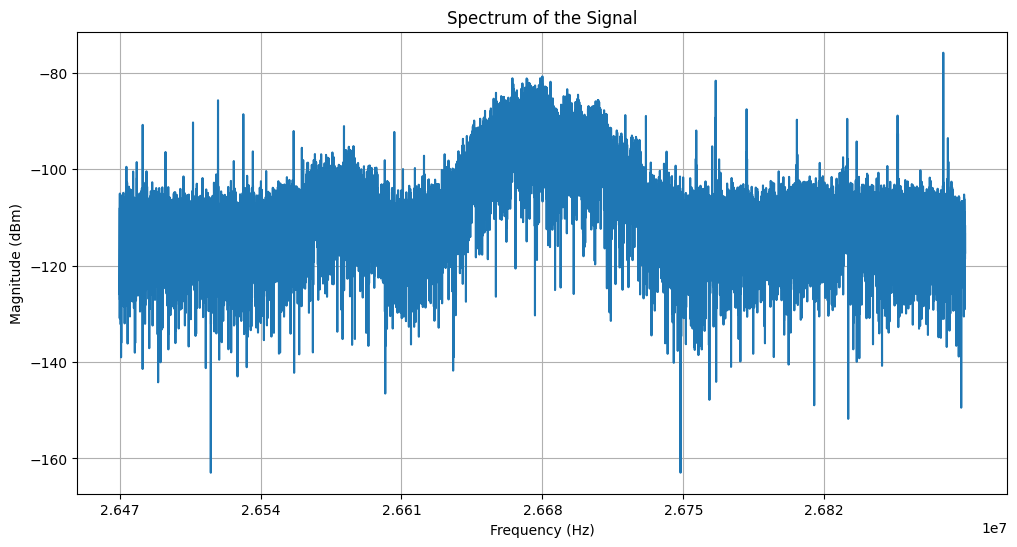

In [158]:
freqs1, spectrum_dbm1 = get_140k_spectrum("baseband_96_34.csv", fs)
freqs2, spectrum_dbm2 = get_140k_spectrum("baseband_96_2.csv", fs)
freqs3, spectrum_dbm3 = get_140k_spectrum("baseband_96_06.csv", fs)

freqs = np.concatenate([freqs1-140e3, freqs2, freqs3+140e3]) + (122.88e6 - 96.2e6)
spectrum_dbm = np.concatenate([spectrum_dbm1, spectrum_dbm2, spectrum_dbm3])

plt.figure(figsize=(12, 6))
plt.plot(freqs, spectrum_dbm)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBm)")
plt.grid()
plt.xticks(np.arange(-210e3 + (122.88e6 - 96.2e6), 210e3 + (122.88e6 - 96.2e6), 70e3))
plt.title("Spectrum of the Signal")

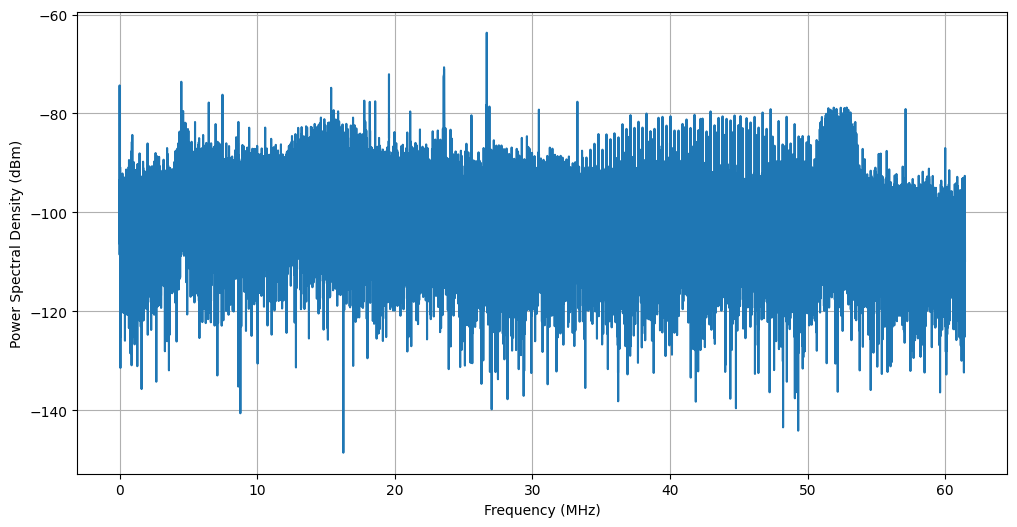

In [122]:
fs = 122.88e6
ts = 1/fs

data = np.loadtxt("received.csv", delimiter=",", skiprows=2)

data = data[:, -1] / 2**15

data = data - np.mean(data)

window = hann(n)
data = data * window

# calculate the spectrum of the signal, and convert to dBm (50ohm)
n = len(data)
fft_data = np.fft.fftshift(np.fft.fft(data)) / n
freqs = np.fft.fftshift(np.fft.fftfreq(n, ts))

# get the positive frequencies and corresponding spectrum
freqs = freqs[n//2:]
fft_data = fft_data[n//2:]

# Convert to dBm (50 ohm load)
power_spectrum = np.abs(fft_data)**2 / 50  # Power in watts
dbm_spectrum = 10 * np.log10(power_spectrum * 1e3)  # Convert to dBm

# plot half spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs / 1e6, dbm_spectrum)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power Spectral Density (dBm)")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Spectrum of the Signal (Zoomed In)')

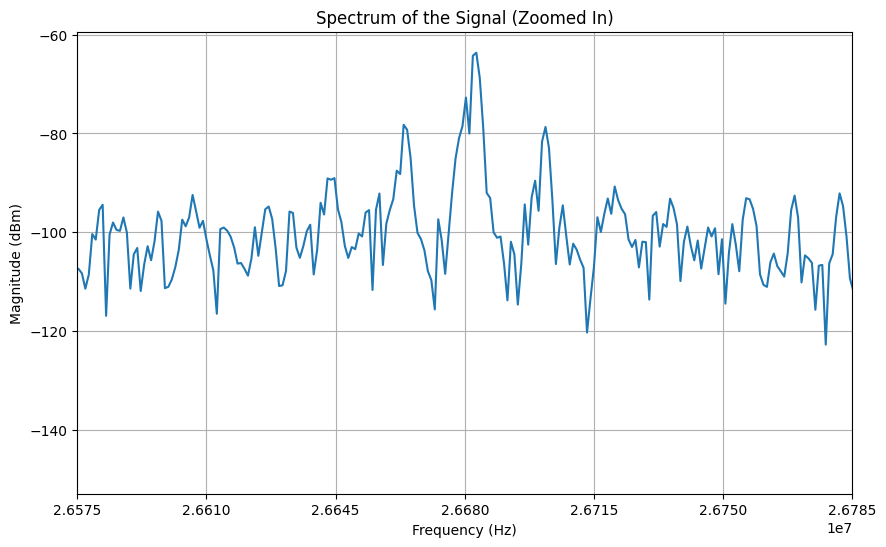

In [124]:
# plot the spectrum of the signal, centered at 30.48MHz, range +- 210kHz
center_freq = 122.88e6-96.2e6
width = 210e3
plt.figure(figsize=(10, 6))
plt.plot(freqs, dbm_spectrum)
plt.xlim(center_freq - width/2, center_freq + width/2)
plt.xticks(np.arange(center_freq - width/2, center_freq + width/2 + 1, 35e3))
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBm)")
plt.title("Spectrum of the Signal (Zoomed In)")

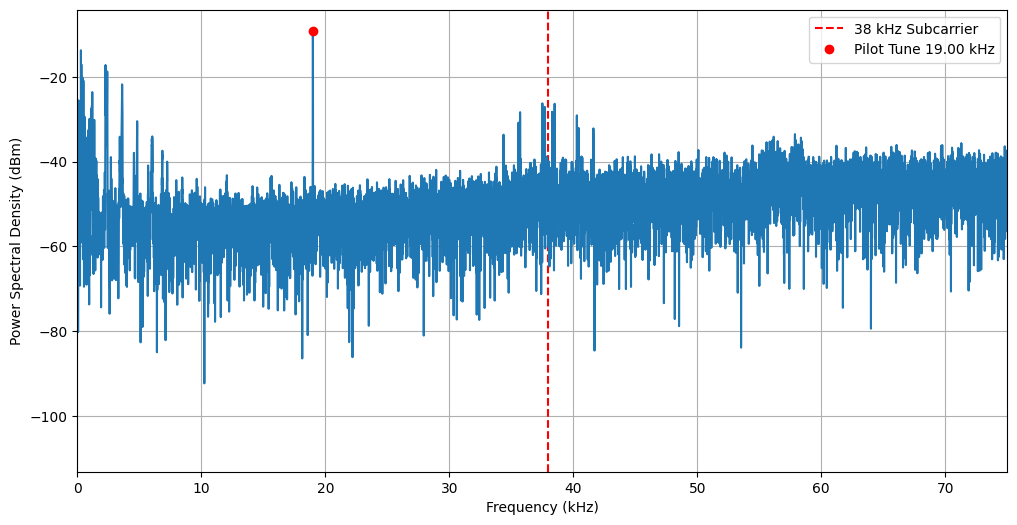

In [ ]:
fs = 960e3
ts = 1/fs

data = np.loadtxt("demodulated_96_2.csv", delimiter=",", skiprows=2)

data = data[:, -1] / 2**29

window = hann(n)
data = data * window

# calculate the spectrum of the signal, and convert to dBm (50ohm)
n = len(data)
fft_data = np.fft.fftshift(np.fft.fft(data)) / n
freqs = np.fft.fftshift(np.fft.fftfreq(n, ts))

# get the positive frequencies and corresponding spectrum
freqs = freqs[n//2:]
fft_data = fft_data[n//2:]

# Convert to dBm (1 ohm load)
power_spectrum = np.abs(fft_data)**2 / 1  # Power in watts
dbm_spectrum = 10 * np.log10(power_spectrum * 1e3)  # Convert to dBm

# plot half spectrum
plt.figure(figsize=(12, 6))
plt.axvline(38, color='r', linestyle='--', label='38 kHz Subcarrier')
plt.plot(freqs / 1e3, dbm_spectrum)
plt.xlim(0, 75)
# plt.xlim(0, 100e3)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Power Spectral Density (dBm)")
plt.grid(True)

# mark the maximum point
max_idx = np.argmax(dbm_spectrum[1:]) + 1  # skip the DC component
plt.plot(freqs[max_idx] / 1e3, dbm_spectrum[max_idx], 'ro', label='Pilot Tone {:.2f} kHz'.format(freqs[max_idx]/1e3))
plt.legend()
plt.show()


In [139]:
fs = 122.88e6
offset_freq = 210e3
fc = 122.88e6 - (96.2e6 + offset_freq)
nco_tw = int((fc / fs) * (2**24))
print("NCO TW for center frequency {} MHz: {} (Hex {})".format(fc/1e6, nco_tw, hex(nco_tw)))

NCO TW for center frequency 26.47 MHz: 3614037 (Hex 0x372555)
